In [1]:
from AC import preproc
from AC import get_news
import inspect
import nltk
nltk.download("stopwords")

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\astefani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
economia = get_news("../articoli_economia/")
cultura = get_news("../articoli_cultura/")
tech = get_news("../articoli_tech/")
politica = get_news("../articoli_politica/")
sport = get_news("../articoli_sport/")
cronaca = get_news("../articoli_cronaca/")

for articolo in economia:
    articolo['categoria'] = "Economia"
for articolo in cultura:
    articolo['categoria'] = "Cultura"
for articolo in tech:
    articolo['categoria'] = "Tech"
for articolo in politica:
    articolo['categoria'] = "Politica"
for articolo in sport:
    articolo['categoria'] = "Sport"
for articolo in cronaca:
    articolo['categoria'] = "Cronaca"
dati_preprocessati =  preproc(tech + politica + cultura + economia + sport + cronaca)

100%|██████████| 2400/2400 [00:17<00:00, 139.61it/s]


In [6]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import linear_model,metrics
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
seed = 0
train_documents,test_documents = train_test_split(dati_preprocessati,random_state=seed,train_size=0.5)
test_documents, val_documents = train_test_split(test_documents,random_state=seed,train_size=0.5)

C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
docs_texts = [' '.join([word for word in x['testo']] + x['tags'] + x['sottotitolo'] + x['titolo_articolo']) for x in dati_preprocessati]
train_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in train_documents]
test_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in test_documents]
val_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in val_documents]

docs_cats = [x["categoria"] for x in dati_preprocessati]
train_cats = [x["categoria"] for x in train_documents]
test_cats = [x["categoria"] for x in test_documents]
val_cats = [x["categoria"] for x in val_documents]

# Classificazione con LDA al variare della dimensione del training set

In [9]:
ldac = Pipeline([
    ("count_mx",CountVectorizer(max_features=1000000, lowercase=True)),
    ("lda", LatentDirichletAllocation(max_iter=50, learning_method='online',random_state=0)),
    ("classifier",DecisionTreeClassifier(random_state=0))
])
params = {
       'lda__n_components': 12,
    'lda__learning_decay': 0.7, 
    'count_mx__ngram_range': (1, 3), 
    'count_mx__min_df': 9, 
    'count_mx__max_df': 0.5, 
    'classifier__min_samples_leaf': 1, 
    'classifier__max_depth': 17

}
ldac.set_params(**params)

conLDA12 = []
for i in [0.15,0.3,0.6]:
    split,s0 = train_test_split(train_documents,random_state=0, train_size = i)
    
    tr_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in split]
    tr_cats = [x["categoria"] for x in split]
    ldac.fit(tr_texts, tr_cats)
    
    pred_cats = ldac.predict(test_texts)
    conLDA12.append({"accuracy_score":metrics.accuracy_score(test_cats, pred_cats),"train_size": i})

# Training con tutto l'insieme
ldac.fit(train_texts, train_cats)
pred_cats = ldac.predict(test_texts)
conLDA12.append({"accuracy_score":metrics.accuracy_score(test_cats, pred_cats),"train_size": 1.0})
    
conLDA12 = pd.DataFrame(conLDA12).sort_values(["train_size","accuracy_score"], ascending=[True,False])
display(conLDA12)

C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,accuracy_score,train_size
0,0.486667,0.15
1,0.705000,0.30
2,0.903333,0.60
3,0.976667,1.00


In [10]:
ldac = Pipeline([
    ("count_mx",CountVectorizer(max_features=1000000, lowercase=True)),
    ("lda", LatentDirichletAllocation(max_iter=50, learning_method='online',random_state=0)),
    ("classifier",DecisionTreeClassifier(random_state=0))
])
params = {
     'lda__n_components': 48,
    'lda__learning_decay': 0.7, 
    'count_mx__ngram_range': (1, 3), 
    'count_mx__min_df': 9, 
    'count_mx__max_df': 0.5, 
    'classifier__min_samples_leaf': 1, 
    'classifier__max_depth': 19

}
ldac.set_params(**params)

conLDA48 = []
for i in [0.15,0.3,0.6]:
    split = train_test_split(train_documents,random_state=0, train_size = i)
    
    tr_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in split[0]]
    tr_cats = [x["categoria"] for x in split[0]]
    ldac.fit(tr_texts, tr_cats)
    
    pred_cats = ldac.predict(test_texts)
    conLDA48.append({"accuracy_score":metrics.accuracy_score(test_cats, pred_cats),"train_size": i})

# Training con tutto l'insieme
ldac.fit(train_texts, train_cats)
pred_cats = ldac.predict(test_texts)
conLDA48.append({"accuracy_score":metrics.accuracy_score(test_cats, pred_cats),"train_size": 1.0})
    
conLDA48 = pd.DataFrame(conLDA48).sort_values(["train_size","accuracy_score"], ascending=[True,False])
display(conLDA48)

C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,accuracy_score,train_size
0,0.571667,0.15
1,0.755000,0.30
2,0.851667,0.60
3,0.978333,1.00


# Classificazione senza LDA al variare della dimensione del training set

In [11]:
tfc = Pipeline([
    ("count_mx", TfidfVectorizer(max_features=1000000, lowercase=True)),
    ("classifier",DecisionTreeClassifier(random_state=0))
]) 
params = { 
    'count_mx__ngram_range': (1, 3), 
    'count_mx__min_df': 9, 
    'count_mx__max_df': 0.5, 
    'classifier__min_samples_leaf': 1, 
    'classifier__max_depth': 29

}
tfc.set_params(**params)

senzaLDA = []
for i in [0.15,0.3,0.6]:
    split = train_test_split(train_documents,random_state=0, train_size = i)
    
    tr_texts = [' '.join([word for word in x['testo']] + x['sottotitolo'] + x['titolo_articolo']) for x in split[0]]
    tr_cats = [x["categoria"] for x in split[0]]
    tfc.fit(tr_texts, tr_cats)

    pred_cats = tfc.predict(test_texts)
    senzaLDA.append({"accuracy_score":metrics.accuracy_score(test_cats, pred_cats),"train_size": i})

# Training con tutto l'insieme
tfc.fit(train_texts, train_cats)
pred_cats = tfc.predict(test_texts)
senzaLDA.append({"accuracy_score":metrics.accuracy_score(test_cats, pred_cats),"train_size": 1.0})

senzaLDA = pd.DataFrame(senzaLDA).sort_values(["train_size","accuracy_score"], ascending=[True,False])
display(senzaLDA)

C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Python\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,accuracy_score,train_size
0,0.596667,0.15
1,0.741667,0.30
2,0.905000,0.60
3,0.978333,1.00


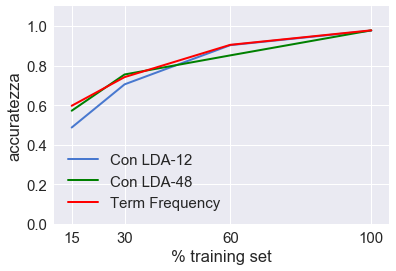

In [12]:
# multiple line plot
plt.style.use('seaborn-darkgrid')
plt.ylim((0,1.1))
plt.xlim((0.1,1.05))
plt.xticks([0.15,0.3,0.6,1.0],["15","30","60","100"])
plt.xlabel("% training set")
plt.ylabel("accuratezza")

plt.plot( 'train_size', 'accuracy_score', data=conLDA12, marker='', linewidth=2)
plt.plot( 'train_size', 'accuracy_score', data=conLDA48, marker='',color='green', linewidth=2)
plt.plot( 'train_size', 'accuracy_score', data=senzaLDA, marker='', color='red', linewidth=2)
plt.legend(['Con LDA-12', 'Con LDA-48', 'Term Frequency'])